**PROJET 1:  Identification Automatique des Ravageurs du Maïs**

**Maguette Diop**<br>
**Ameth Sylla**<br>
**Ndeye Galass Gaye**<br>
**Omar Sall**<br>
**Ramatoulay Diallo**<br>

**NB**: Ce projet est réalisé sur **Google-Colab**

In [180]:
from google.colab import drive, files
drive.mount("/content/0", force_remount=True)

Mounted at /content/0


In [181]:
%pip install keras -q

In [182]:
!unzip -o -q /content/0/MyDrive/Project_1_data_img/Project_1_data_img.zip

In [183]:
from pathlib import Path
import os

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import PIL
import PIL.Image

import tensorflow as tf
from tensorflow.keras import models, layers
import tensorflow_datasets as tfds

print("Version", tf.__version__)

Version 2.15.0


In [184]:
# Dossier de travail
DATA_DIR = Path("/content/Project_1_data_img/")

## - Suppression des format d'image non pris en charge par tensorflow et des fichiers corrompus

In [185]:
from pathlib import Path
import imghdr

image_extensions = ["webp", "jpeg", "", ".png", ".jpg", "JPG"]

img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]
for d in DATA_DIR.iterdir():
    for filepath in d.iterdir():
        if filepath.suffix.lower() in image_extensions:
            img_type = imghdr.what(filepath)
            if img_type is None:
                os.remove(filepath)
            elif img_type not in img_type_accepted_by_tf:
                os.remove(filepath)
            else:
              pass
        else:
            os.remove(filepath)

In [229]:
# Les donnees sont structurees par dossier, chaque dossier represente une classe
classes = [d.name for d in DATA_DIR.iterdir()]
classes

['chenille', 'puceron', 'leaf beetle', 'grasshoper', 'healthy']

In [230]:
# some contants here
batch_size = 16
img_height = 128
img_width = 128
channels = 3
epochs = 50

# 1- Creation d'un ensemble de donnees annotees en format de dataset  tensorflow

In [236]:
extensions = ["jpg", "JPG"]
image_ds = tf.data.Dataset.list_files([f"{DATA_DIR.name}/*/*.{extension}" for extension in extensions], shuffle=False)
image_count = len(image_ds)
image_ds = image_ds.shuffle(image_count, reshuffle_each_iteration=False)

# recuperation d'un nom de classe
def get_label(img_path):
  return tf.argmax(tf.strings.split(img_path, "/")[1] == classes)

# chargement d'une image
def read_img(img_path):
  img = tf.io.decode_jpeg(img_path, channels=channels)
  img = tf.image.resize(img, [img_height, img_width])
  return img

def process_img(img_path):
  label = get_label(img_path)
  img = tf.io.read_file(img_path)
  image = read_img(img)
  return image, label


image_ds = image_ds.map(process_img)

print(f"Total : {image_count} images")

Total : 6844 images


# 2- Division du dataset en ensemble d'entrainement, de validation et de test
### 80 % pour l'entrainement  
### 10 % pour la validation  
### 10 % pour le test  

In [237]:
image_ds = image_ds.batch(batch_size)

def split_dataset(ds, ds_partitions=(0.8, 0.1, 0.1)):
  ds_size = len(ds)
  train_size, val_size, test_size = map(lambda x: int(x * ds_size), ds_partitions)

  train_ds = ds.take(train_size)
  val_ds = ds.skip(train_size).take(val_size)
  test_ds = ds.skip(train_size).skip(val_size)

  return train_ds, val_ds, test_ds

train_ds, val_ds, test_ds = split_dataset(image_ds)

def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
  return ds


train_ds, val_ds, test_ds = [configure_for_performance(ds) for ds in [train_ds, val_ds, test_ds]]

print(f"""
Train : {len(train_ds)},
Validation : {len(val_ds)},
Test : {len(test_ds)}
""")


Train : 342,
Validation : 42,
Test : 44



# -- Le pretraitements et la normalisation des images sont integres dans l'architecture du modele

# -- Une couche d'augmentation de donnee a ete ajouter pour consolider le modele

# 3- Modelisation

## -Architecture du modele

In [194]:
input_shape = (batch_size, img_height, img_width, channels)
n_classes = len(classes)

model = models.Sequential([
  # couche de normalisation
  layers.experimental.preprocessing.Resizing(img_height, img_width),
  layers.experimental.preprocessing.Rescaling(1.0/255),

  # couche d'augementation de donnee
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),

  # couches de convolution
  layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
  layers.MaxPooling2D((2, 2)),
  layers.Flatten(),
  layers.Dense(64, activation='relu'),
  layers.Dense(n_classes, activation='softmax')
])

model.build(input_shape=input_shape)
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_4 (Resizing)       (16, 128, 128, 3)         0         
                                                                 
 rescaling_4 (Rescaling)     (16, 128, 128, 3)         0         
                                                                 
 random_flip_4 (RandomFlip)  (16, 128, 128, 3)         0         
                                                                 
 random_rotation_4 (RandomR  (16, 128, 128, 3)         0         
 otation)                                                        
                                                                 
 conv2d_28 (Conv2D)          (16, 128, 128, 32)        896       
                                                                 
 max_pooling2d_28 (MaxPooli  (16, 64, 64, 32)          0         
 ng2D)                                                

In [195]:
history = model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"]
)

## - Entrainement du modele

In [196]:
trainning_history = model.fit(
    train_ds,
    epochs=epochs,
    batch_size=batch_size,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/50
342/342 [==============================] - 224s 646ms/step - loss: 1.4620 - accuracy: 0.3511 - val_loss: 1.4434 - val_accuracy: 0.3616
Epoch 2/50
342/342 [==============================] - 193s 565ms/step - loss: 1.1560 - accuracy: 0.5201 - val_loss: 0.8965 - val_accuracy: 0.6696
Epoch 3/50
342/342 [==============================] - 176s 516ms/step - loss: 0.7651 - accuracy: 0.7242 - val_loss: 0.7163 - val_accuracy: 0.7500
Epoch 4/50
342/342 [==============================] - 179s 523ms/step - loss: 0.6663 - accuracy: 0.7611 - val_loss: 0.6555 - val_accuracy: 0.7887
Epoch 5/50
342/342 [==============================] - 224s 656ms/step - loss: 0.6097 - accuracy: 0.7840 - val_loss: 0.6393 - val_accuracy: 0.7872
Epoch 6/50
342/342 [==============================] - 246s 719ms/step - loss: 0.5805 - accuracy: 0.7946 - val_loss: 0.5344 - val_accuracy: 0.8289
Epoch 7/50
342/342 [==============================] - 241s 703ms/step - loss: 0.5482 - accuracy: 0.8094 - val_loss: 0.5592 -

# 4- Validation et Evaluation du modele

## - Validation sur l'ensemble de test

In [197]:
score = model.evaluate(test_ds)

44/44 [==============================] - 20s 150ms/step - loss: 0.3320 - accuracy: 0.9071


Text(0.5, 1.0, 'Loss')

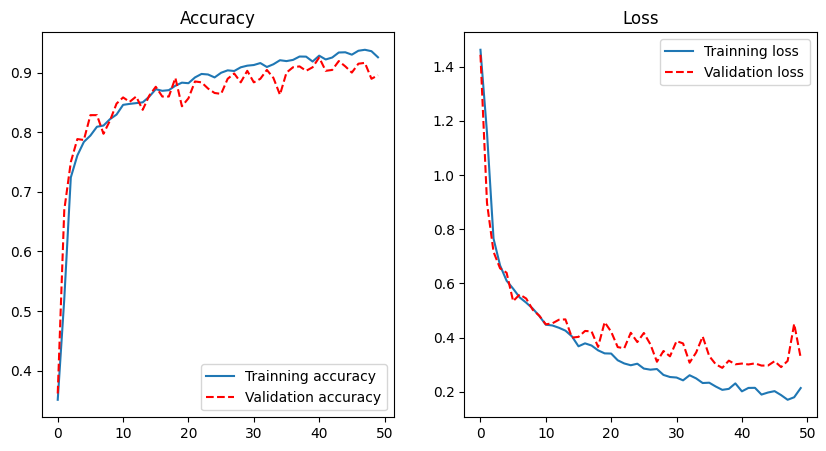

In [198]:
train_acc = trainning_history.history.get('accuracy')
val_acc = trainning_history.history.get('val_accuracy')
train_loss = trainning_history.history.get('loss')
val_loss = trainning_history.history.get('val_loss')

plt.figure(figsize=(10, 5))
# accuracy curve
plt.subplot(1, 2, 1)
plt.plot(range(epochs), train_acc, label="Trainning accuracy")
plt.plot(range(epochs), val_acc, "r--", label="Validation accuracy")
plt.legend()
plt.title("Accuracy")

plt.subplot(1, 2, 2)
plt.plot(range(epochs), train_loss, label="Trainning loss")
plt.plot(range(epochs), val_loss, "r--", label="Validation loss")
plt.legend()
plt.title("Loss")

In [232]:
def predict(model, img):
  img_array = tf.keras.preprocessing.image.img_to_array(img.numpy())
  img_array = tf.expand_dims(img_array, 0)

  predictions = model.predict(img_array)
  predicted_class = classes[np.argmax(predictions[0])]
  confidence = round(100*(np.max(predictions[0])), 2)

  return predicted_class, confidence

1/1 [==============================] - 0s 29ms/step


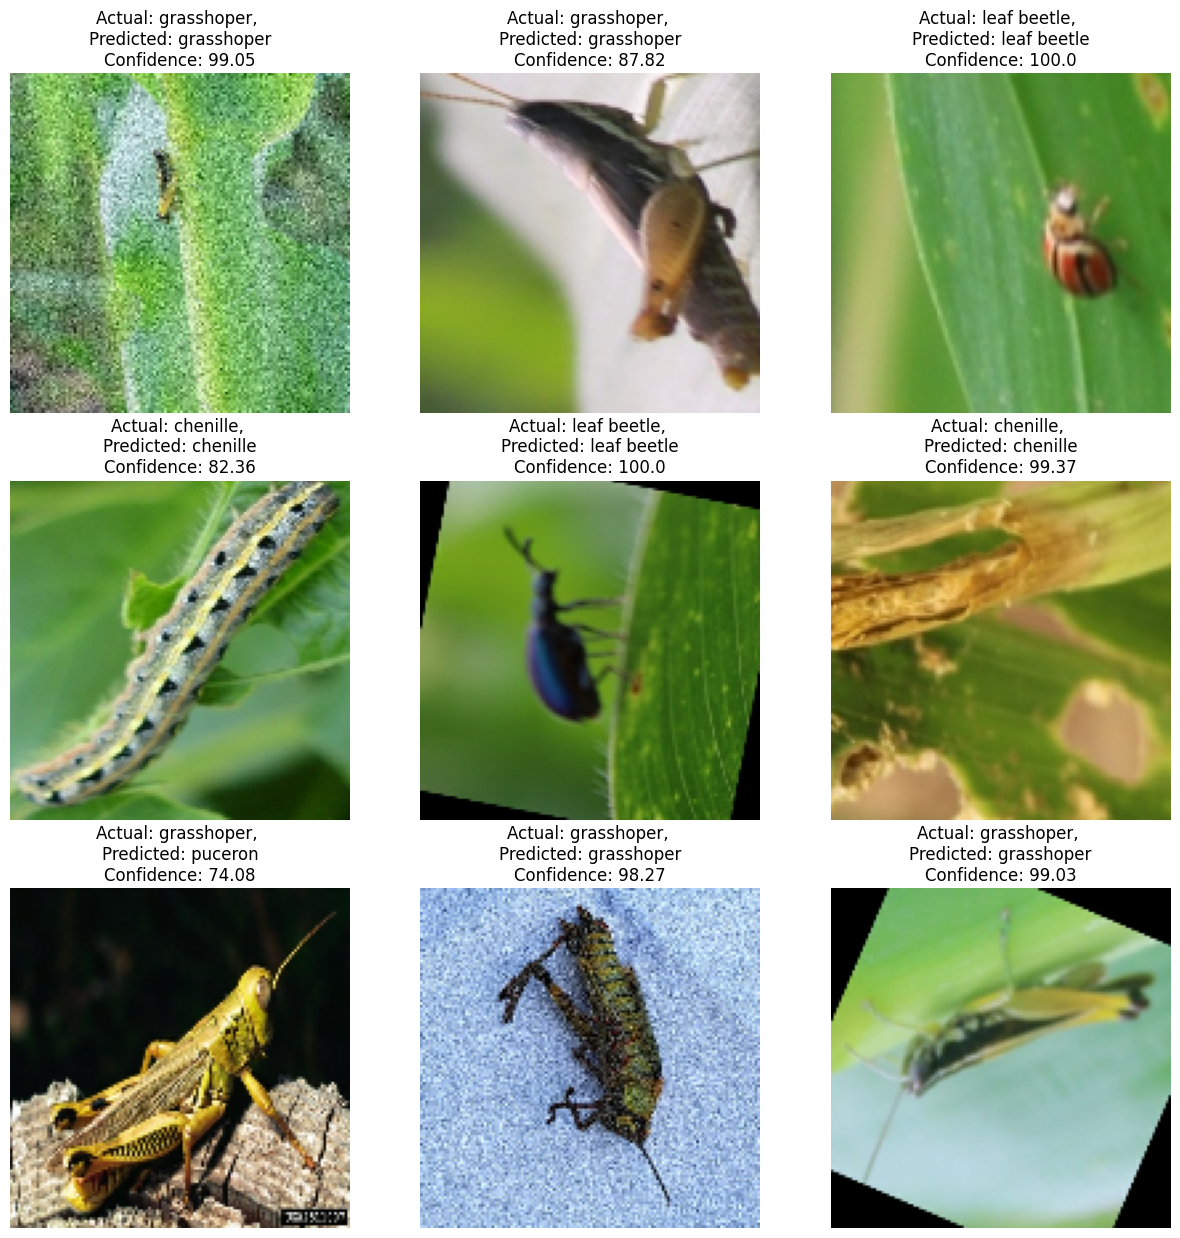

In [238]:
plt.figure(figsize=(15, 15))
for images, labels in image_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(images[i].numpy().astype("uint8"))

    predicted_class, confidence = predict(model, images[i])
    actual_class = classes[labels[i]]

    plt.title(f"Actual: {actual_class}, \nPredicted: {predicted_class}\nConfidence: {confidence}")
    plt.axis("off")

## - Calcul des metrics

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score


trained_y, predicted_y = [], []

for images, labels in image_ds.take(10):
  for i in range(16):
    predicted_class, confidence = predict(model, images[i])
    actual_class = classes[labels[i]]

    trained_y.append(actual_class)
    predicted_y.append(predicted_class)

In [223]:
from sklearn.metrics import f1_score, precision_score, recall_score

def get_metrics(class_to_test, trained_labels, predicted_labels):
  train_y = [1 if class_name == class_to_test else 0 for class_name in trained_labels]
  pred_y = [1 if class_name == class_to_test else 0 for class_name in predicted_labels]

  precision = precision_score(train_y, pred_y)
  rappel = recall_score(train_y, pred_y)
  f1_Score = f1_score(train_y, pred_y)
  return precision, rappel, f1_Score


for c in classes:
  precision, rappel, score = get_metrics(c, trained_y, predicted_y)
  print(f"""
  Metrics for class '{c}':
    Precision : {precision},
    Rappel : {rappel},
    F1-score : {score}
  """)



  Metrics for class 'chenille':
    Precision : 0.9714285714285714,
    Rappel : 0.9714285714285714,
    F1-score : 0.9714285714285714
  

  Metrics for class 'puceron':
    Precision : 0.5,
    Rappel : 1.0,
    F1-score : 0.6666666666666666
  

  Metrics for class 'leaf beetle':
    Precision : 1.0,
    Rappel : 0.926829268292683,
    F1-score : 0.9620253164556963
  

  Metrics for class 'grasshoper':
    Precision : 0.9666666666666667,
    Rappel : 0.9666666666666667,
    F1-score : 0.9666666666666667
  

  Metrics for class 'healthy':
    Precision : 1.0,
    Rappel : 1.0,
    F1-score : 1.0
  


In [214]:
model_path = Path(Path().cwd() / "models")
model_path.mkdir(exist_ok=True)

In [204]:
model_version = 2
model.save(f"{model_path}/{model_version}")

In [205]:
!zip -r -q model_1.zip /content/models/2/

In [206]:
files.download("/content/model_1.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>